In [12]:
import hlm
import numpy as np
import copy 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from hlm.utils import south

In [13]:
data = south()
model = hlm.both.MVCM(**data, n_samples=0, tuning=2000)

In [14]:
model.sample(10000, n_jobs = 4)

/home/ljw/anaconda3/envs/py3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


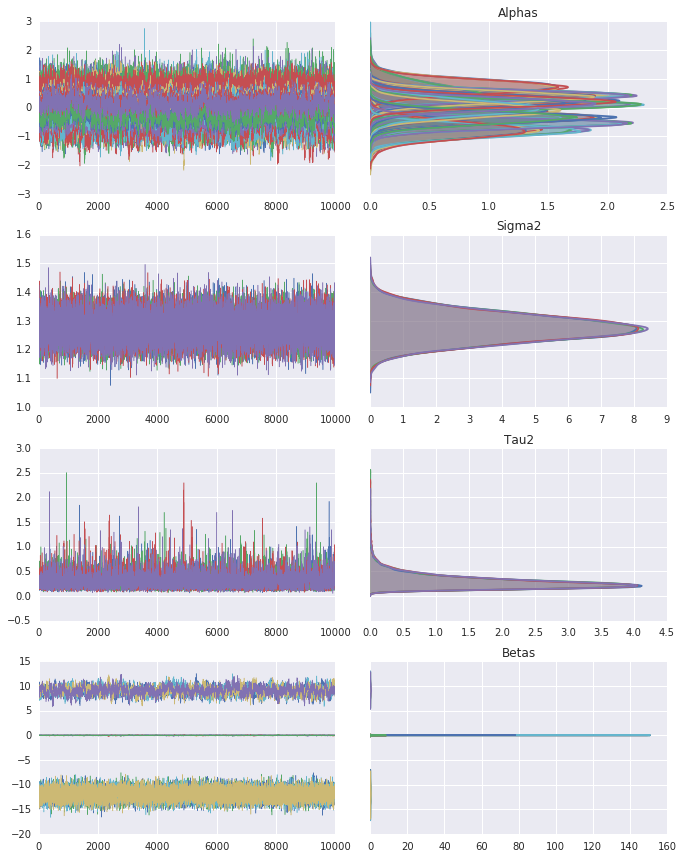

In [15]:
model.trace.plot()
plt.tight_layout()
plt.show()

In [547]:
df = model.trace.to_df()

In [551]:
df[0][['Sigma2', 'Tau2', 'Betas_0']].to_csv('./example_trace.csv')

In [17]:
____protect_me = model

In [537]:
def _geweke_from_coda(data, drop, hold):
    
    hold_start = np.floor((len(data)-1) * hold)
    bin_width = np.ceil((len(data)-1) * drop)
    
    drop_data = data[:bin_width]
    hold_data = data[hold_start:]
    
    drop_mean = drop_data.mean()
    drop_var = _spectrum_ar0(drop_data)
    n_drop = len(drop_data)
    
    hold_mean = hold_data.mean()
    hold_var = _spectrum_ar0(hold_data)
    n_hold = len(hold_data)
    
    return (drop_mean - hold_mean)/np.sqrt((drop_var / n_drop) + (hold_var / n_hold))

def _recur_geweke(data, drop, hold, n_bins):
    in_play = len(data-1) //2
    to_drop = np.linspace(0, in_play, num=n_bins).astype(int)
    
    return to_drop, [_geweke_from_coda(data[drop_idx:], drop, hold) for drop_idx in to_drop]
        

def geweke(model = None, trace=None, chain=None, 
           drop_frac=.1, keep_frac=.5, n_bins=50, 
           varnames=None, variance_method='ar0', **kw):
    """
    This computes Geweke's statistic for a given chain, model, or trace. 
    
    Arguments
    ----------
    """
    trace = _resolve_to_trace(model, trace, chain, varnames)
    varnames = trace.varnames
    m,niter = trace[0,varnames[0]].shape[0:2]
    results = []
    for ichain, chain in enumerate(trace.chains):
        this_chain_results = dict()
        for varname in varnames:
            this_chain_results.update({varname:dict()})
            data = np.squeeze(trace[ichain, varname])
            n = data.shape[0]
            if len(data.shape) == 1:
                data = data.reshape(n,1)
            n,k = data.shape
            outvarnames = [varname + '_{}'.format(i) for i in range(k)]
            this_param_results = []
            for iparam, param_data in enumerate(data.T):
                result_ary = _recur_geweke(param_data, drop_frac, keep_frac, n_bins)
                this_param_results.append(result_ary)
            this_chain_results[varname] = np.asarray(this_param_results)
        results.append(this_chain_results)
    return results
    

def _resolve_to_trace(model, trace, chain, varnames):
    if trace is not None:
        if varnames is not None:
            return trace.drop([var for var in trace.varnames
                               if var not in varnames], inplace=False)
        else:
            return copy.deepcopy(trace)
    if model is not None:
        return _resolve_to_trace(model=None, trace=model.trace,
                                 chain=None, varnames=varnames)
    if chain is not None:
        m,n = chain.shape[0:2]
        rest = chain.shape[2:]
        new_p = np.multiply(*rest)
        chain = chain.reshape(m,n,new_p)
        if varnames is None:
            varnames = ['parameter_{}'.format(i) for i in new_p]
        else:
            if len(varnames) != new_p:
                raise NotImplementedError('Parameter Subsetting by varnames '
                                  'is not currenlty implented for raw arrays')
        return Trace([Hashmap({k:run.T[p] for p,k in enumerate(varnames)})
                      for run in chain])
        
def _naive_var(x, *_, **__):
    """
    Naive variance computation of a time `x`, ignoring dependence between the
    variance within different windows
    """
    return np.var(x, ddof=1)

def _spectrum_ar0(data, spec_kw=dict(), fit_kw=dict()):
    """
    The corrected spectral density estimate of time series variance,
    as applied in CODA
    """
    try:
        from statsmodels.api import tsa
    except ImportError:
        raise ImportError('Statsmodels is required to use the AR(0) '
                           ' spectral density estimate of the variance.')
    fit_kw['ic'] = fit_kw.get('ic', 'aic')
    ARM = tsa.AR(data, **spec_kw).fit(**fit_kw)
    alphas = ARM.params[1:].sum()
    return ARM.sigma2 / (1 - alphas.sum())**2

            

_geweke_variance = dict()
_geweke_variance['ar0'] = _spectrum_ar0
_geweke_variance['naive'] = _naive_var


In [540]:
results = geweke(model)

/home/ljw/anaconda3/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/ljw/anaconda3/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


KeyboardInterrupt: 

In [552]:
!ls

baltim_svcp.ipynb				   svcptest.ipynb
example_trace					   test_0.csv
example_trace.csv				   test_0..csv
geweke.ipynb					   test_1.csv
hlm						   test_1..csv
Notes on Progress in Fitting Spatial Models.ipynb  test_2.csv
parallel.ipynb					   Untitled1.ipynb
parameter recovery.ipynb			   Untitled2.ipynb
psrf.ipynb					   Untitled.ipynb
review_models.ipynb				   using the sampler.ipynb
sandbox.ipynb					   x25_data.csv
serialization.ipynb


In [538]:
idx, score = mc.geweke(model.trace[0, 'Tau2']).T

In [541]:
idx_, score_ = _recur_geweke(model.trace[0, 'Tau2'], .1, .5, 20)

/home/ljw/anaconda3/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/ljw/anaconda3/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [542]:
idx

array([    0.,   263.,   526.,   789.,  1052.,  1315.,  1578.,  1841.,
        2104.,  2367.,  2630.,  2893.,  3156.,  3419.,  3682.,  3945.,
        4208.,  4471.,  4734.,  4997.])

In [543]:
idx_

array([   0,  263,  526,  789, 1052, 1315, 1578, 1842, 2105, 2368, 2631,
       2894, 3157, 3421, 3684, 3947, 4210, 4473, 4736, 5000])

In [544]:
score

array([-0.04745614, -0.07043915, -0.03982442, -0.0637843 , -0.03761676,
       -0.01563558, -0.07591208, -0.02189076, -0.04537059, -0.01239839,
       -0.00727118,  0.0352076 , -0.00062399, -0.05753478, -0.15423778,
       -0.13385788, -0.11707629, -0.07766731, -0.05473636,  0.00513554])

In [545]:
scores, arvar, nvar = list(zip(*score_))

TypeError: zip argument #1 must support iteration

In [546]:
section_arvar, hold_arvar = zip(*arvar)
section_nvar, hold_nvar = zip(*nvar)

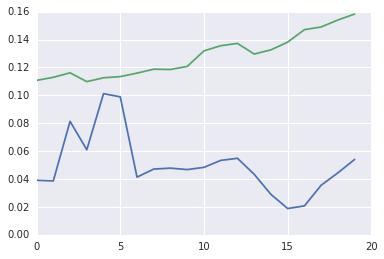

In [463]:
plt.plot(section_arvar)
plt.plot(hold_arvar)

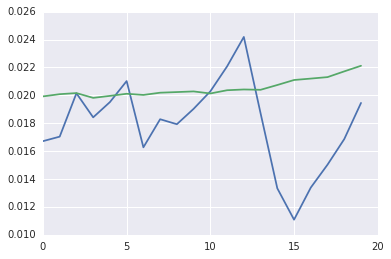

In [464]:
plt.plot(section_nvar)
plt.plot(hold_nvar)

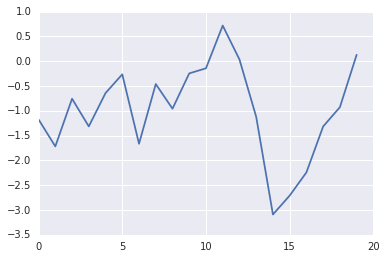

In [465]:
plt.plot(scores)

In [411]:
%%R
library(coda)
coda::spectrum0.ar

function (x) 
{
    x <- as.matrix(x)
    v0 <- order <- numeric(ncol(x))
    names(v0) <- names(order) <- colnames(x)
    z <- 1:nrow(x)
    for (i in 1:ncol(x)) {
        lm.out <- lm(x[, i] ~ z)
        if (identical(all.equal(sd(residuals(lm.out)), 0), TRUE)) {
            v0[i] <- 0
            order[i] <- 0
        }
        else {
            ar.out <- ar(x[, i], aic = TRUE)
            v0[i] <- ar.out$var.pred/(1 - sum(ar.out$ar))^2
            order[i] <- ar.out$order
        }
    }
    return(list(spec = v0, order = order))
}
<environment: namespace:coda>


In [412]:
%Rpush data

In [416]:
%%R
data <- as.matrix(data)
spectrum0.ar(data)

$spec
[1] 0.08156986

$order
[1] 12



In [431]:
%%R
AR <- ar(data)

In [436]:
%R names(AR)

array(['order', 'ar', 'var.pred', 'x.mean', 'aic', 'n.used', 'order.max',
       'partialacf', 'resid', 'method', 'series', 'frequency', 'call',
       'asy.var.coef'], 
      dtype='<U12')

In [438]:
%R AR$ar

array([ 0.22292174,  0.05539009,  0.04352256,  0.04053314,  0.05606448,
        0.01104914,  0.02561763,  0.02004394,  0.01145017,  0.02031426,
        0.01960345,  0.01600544])

In [448]:
%R sum(AR$ar)

array([ 0.54251604])

In [449]:
smparams.sum()

0.54260957539528132

In [450]:
%R AR$var.pred

array([ 0.01707188])

In [452]:
ARM.sigma2

0.017064635288322239

In [444]:
smparams = ARM.params[1:]

In [446]:
Rar = %R AR$ar

In [447]:
smparams - Rar

array([  2.54312727e-05,  -3.18268208e-05,  -3.46565355e-05,
        -2.42199017e-05,   5.31190150e-05,  -5.93749882e-05,
         6.09018425e-05,   1.99803003e-05,   3.86226540e-05,
         4.19591859e-05,  -1.22504443e-06,   4.82083452e-06])

# COMPARE PYMC3, CODA, and ME

In [510]:
data = model.trace[0,'Tau2'].reshape(-1,1)

In [511]:
%Rpush data

In [526]:
%%R

mcdata <- as.mcmc(data)

ystart <- seq(from=start(mcdata), to=(start(mcdata)+end(mcdata))/2, length=20)
r_scores <- c()
for(n in 1:length(ystart)){
    geweke_out <- coda::geweke.diag(window(mcdata, start=ystart[n]), frac1=.1, frac2=.5)
    r_scores <- cbind(r_scores, geweke_out$z)
    
}

In [527]:
%R r_scores

array([[-1.06586229, -1.69412218, -0.78815496, -1.25647688, -0.65227514,
        -0.24940224, -1.65274501, -0.4438748 , -0.95170464, -0.23319892,
        -0.16715112,  0.73188081, -0.01671143, -1.18789014, -3.10418554,
        -2.68601958, -2.1671078 , -1.34015214, -0.92511342,  0.16360419]])

In [528]:
idx, my_scores = _recur_geweke(data, .1, .5, 20)

/home/ljw/anaconda3/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/ljw/anaconda3/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [529]:
%Rpull r_scores

In [530]:
r_scores

array([[-1.06586229, -1.69412218, -0.78815496, -1.25647688, -0.65227514,
        -0.24940224, -1.65274501, -0.4438748 , -0.95170464, -0.23319892,
        -0.16715112,  0.73188081, -0.01671143, -1.18789014, -3.10418554,
        -2.68601958, -2.1671078 , -1.34015214, -0.92511342,  0.16360419]])

In [531]:
np.asarray(my_scores)

array([-1.17481826, -1.71764094, -0.75663308, -1.31430499, -0.64213108,
       -0.26499492, -1.66443412, -0.46045521, -0.95789157, -0.24596854,
       -0.14284958,  0.71836405,  0.034852  , -1.12100181, -3.09020262,
       -2.70923032, -2.24213762, -1.31593895, -0.92711638,  0.1291041 ])

In [533]:
pymc_scores = mc.geweke(data.flatten()).T[1]
pymc_scores

array([-0.04745614, -0.07043915, -0.03982442, -0.0637843 , -0.03761676,
       -0.01563558, -0.07591208, -0.02189076, -0.04537059, -0.01239839,
       -0.00727118,  0.0352076 , -0.00062399, -0.05753478, -0.15423778,
       -0.13385788, -0.11707629, -0.07766731, -0.05473636,  0.00513554])

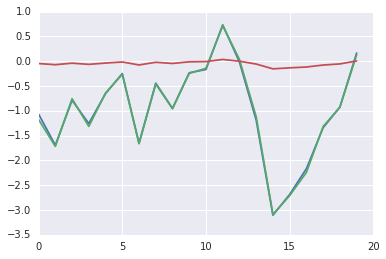

In [536]:
plt.plot(np.vstack((r_scores, my_scores, pymc_scores)).T)

In [443]:
ARM = tsa.AR(data).fit(ic='aic', trend='c')


array([ 0.22294717,  0.05535826,  0.0434879 ,  0.04050892,  0.0561176 ,
        0.01098977,  0.02567853,  0.02006392,  0.01148879,  0.02035622,
        0.01960223,  0.01601026])

plt.plot(_windowed_geweke(model.trace[2,'Betas'][:,0], .1, .5, 20, variance_method='naive'), color='g')
plt.plot(_geweke_zscores(model.trace[2,'Betas'][:,0], .1, .5, 20, variance_method='naive'), color='b')
plt.plot(mc.geweke(model.trace[2,'Betas'][:,0])[0].T[1], color='r')
#plt.hlines(1.96, 0, 50, 'k', linestyle=":")
#plt.hlines(-1.96, 0,50,'k', linestyle=':')

/home/ljw/anaconda3/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:38: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/ljw/anaconda3/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
/home/ljw/anaconda3/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


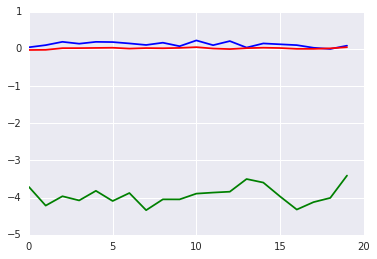

In [231]:
plt.plot(_windowed_geweke(model.trace[1,'Sigma2'], .1, .5, 20), color='g')
plt.plot(_geweke_zscores(model.trace[1,'Sigma2'], .1, .5, 20), color='b')
plt.plot(mc.geweke(model.trace[1,'Sigma2']).T[1], color='r')
#plt.hlines(1.96, 0, 50, 'k', linestyle=":")
#plt.hlines(-1.96, 0,50,'k', linestyle=':')

In [209]:
mc.geweke(model.trace[2,'Sigma2']).T[1]

array([-0.00248685, -0.00456752, -0.00363131,  0.00819941, -0.0153821 ,
       -0.00048481,  0.00892801, -0.00144624,  0.00269711,  0.00512249,
        0.04596322,  0.04480582,  0.00908335,  0.01869597,  0.0542839 ,
        0.08072884,  0.02589873,  0.04676324,  0.05225847,  0.03568959])

In [199]:
stats

[-0.20266815803296256,
 -0.2000906230086586,
 -0.24151793770515884,
 0.036319035531711452,
 0.036162445971761881,
 0.041116866326797896,
 -0.0038526764390610091,
 0.054620667107417975,
 0.095390143911773084,
 -0.033049420543132368,
 -0.055479451969852545,
 -0.21244338552702818,
 -0.22775184748351901,
 -0.20716786748339339,
 -0.22979812603888838,
 -0.057716425040353792,
 -0.059851164612302277,
 0.14135831495469561,
 0.14425255603948892,
 -0.26424270891246782]

In [54]:
tau2_run = model.trace[0,'Tau2']

In [55]:
%Rpush tau2_run

In [97]:
%%R

tau2 <- t(as.matrix(tau2_run))

In [99]:
%%R
length(dim(tau2))

[1] 2


In [105]:
%%R

boa::boa.chain.del('tau2')
boa::boa.chain.add(tau2, 'tau2')

[1] TRUE


In [106]:
%%R

boa.plot.geweke('tau2')


Error in match(el, set, 0L) : 
  argument "pname" is missing, with no default
